In [1]:
#Author-Vishal Burman

In [2]:
#Free-up the GPU memory

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

c:\users\vishal\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#Importing the relevant libraries

import os, shutil
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import adam
from keras.applications import VGG16
from keras import optimizers

Using TensorFlow backend.


In [4]:
#Specify the base directory

base_dir="cats_and_dog_small/"

In [5]:
#Specifying the Training, Validation and Test directory

train_dir=os.path.join(base_dir, 'train')
validation_dir=os.path.join(base_dir, 'valid')
test_dir=os.path.join(base_dir, 'test')

train_cats_dir=os.path.join(train_dir, 'cats')
train_dogs_dir=os.path.join(train_dir, 'dogs')

validation_cats_dir=os.path.join(validation_dir, 'cats')
validation_dogs_dir=os.path.join(validation_dir, 'dogs')

test_cats_dir=os.path.join(test_dir, 'cats')
test_dogs_dir=os.path.join(test_dir, 'dogs')

In [6]:
#Instantiating the VGG16 Convolution Base

conv_base=VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

In [ ]:
"""

include_top: we do not intend to include the 1000 classes of ImageNet since we are working on custom dataset
             therefore we won't include it.

weights: we import the weights of the VGG16 trained on ImageNet dataset

"""

In [7]:
#Adding a densely connected classifier on top of the Convolution base

model=Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
#Model Summary

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              16781312  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4097      
Total params: 65,058,625
Trainable params: 57,423,361
Non-trainable params: 7,635,264
_________________________________________________________________


In [10]:
#Fine-Tuning the VGG16 model by training the last layer

conv_base.trainable=True

set_trainable=False
for layer in conv_base.layers:
    if layer.name=="block5_conv1":
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

In [11]:
#Configuring the Data Augmentation part of the model

train_datagen=ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator=test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

In [13]:
#Compiling the model

model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=1e-5), metrics=['accuracy'])

In [15]:
#Fitting the model

history=model.fit_generator(train_generator, steps_per_epoch=100, epochs=5, validation_data=validation_generator, validation_steps=50, workers=8)

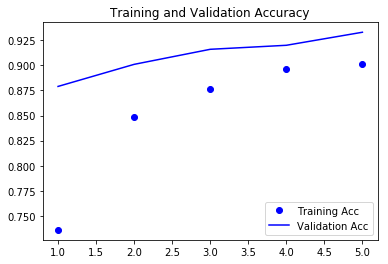

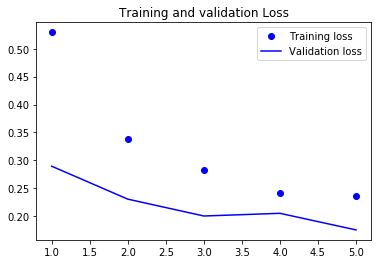

In [17]:
#Displaying the curves of loss and accuracy during training

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend()

In [ ]:
"""

In the above model we see that in 5 epochs there is an amazing increase in the accuracy with just 2000 training images

"""

In [18]:
#Testing the accuracy

In [19]:
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(150, 150),batch_size=20,class_mode='binary')
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9219999957084656


In [ ]:
"""

We see that fine-tuning pre-trained ConvNets produce amazing results. Accuracy=92%

"""